# Imports

https://huggingface.co/llava-hf/llava-onevision-qwen2-0.5b-ov-hf

In [1]:
import os
import cv2
import time
import json
import PIL
from PIL import Image
import base64
from PIL import Image
from pathlib import Path
from os import path as osp
# from moviepy.editor import VideoFileClip

In [2]:
import torch
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration

In [3]:
model_id = "llava-hf/llava-onevision-qwen2-0.5b-ov-hf"
model = LlavaOnevisionForConditionalGeneration.from_pretrained(model_id, torch_dtype=torch.float16, low_cpu_mem_usage=True).to(0)
processor = AutoProcessor.from_pretrained(model_id)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
def lvlm_inference_hugginface(image_path):
    conversation = [
                        {
                    
                          "role": "user",
                          "content": [
                              {"type": "text", "text": "Can you describe the image??"},
                              {"type": "image"},
                            ],
                        },
                    ]
    prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

    im = Image.open(image_path)
    inputs = processor(images=im, text=prompt, return_tensors='pt').to(0, torch.float16)
    output = model.generate(**inputs, max_new_tokens=200, do_sample=False)
    res = processor.decode(output[0], skip_special_tokens=True)
    res = res.split("assistant\n", 1)[-1]

    return res

In [ ]:
# pth = 'sample_videos/extracted_frames/frame_17.jpg'
# lvlm_inference_hugginface(pth)

# Helper Functions

In [5]:
# Resizes a image and maintains aspect ratio
def maintain_aspect_ratio_resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    # Grab the image size and initialize dimensions
    dim = None
    (h, w) = image.shape[:2]

    # Return original image if no need to resize
    if width is None and height is None:
        return image

    # We are resizing height if width is none
    if width is None:
        # Calculate the ratio of the height and construct the dimensions
        r = height / float(h)
        dim = (int(w * r), height)
    # We are resizing width if height is none
    else:
        # Calculate the ratio of the width and construct the dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # Return the resized image
    return cv2.resize(image, dim, interpolation=inter)

In [6]:
# encoding image at given path or PIL Image using base64
def encode_image(image_path_or_PIL_img):
    if isinstance(image_path_or_PIL_img, PIL.Image.Image):
        # this is a PIL image
        buffered = BytesIO()
        image_path_or_PIL_img.save(buffered, format="JPEG")
        return base64.b64encode(buffered.getvalue()).decode('utf-8')
    else:
        # this is a image_path
        with open(image_path_or_PIL_img, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')

# Preprocessing

#### Video to Frames

In [7]:
path_to_video = 'sample_videos/fire2.mp4'
path_to_save_extracted_frames = 'sample_videos/extracted_frames/'
path_to_save_metadatas = 'sample_videos/extracted_metadata/'
num_of_extracted_frames_per_second = 1/10

In [8]:
# metadatas will store the metadata of all extracted frames
metadatas = []

# load video using cv2
video = cv2.VideoCapture(path_to_video)

In [9]:
# Get the frames per second
fps = video.get(cv2.CAP_PROP_FPS)

In [10]:
fps

23.976023976023978

In [11]:
# Get hop = the number of frames pass before a frame is extracted
hop = round(fps / num_of_extracted_frames_per_second) 
hop

240

In [12]:
t1 = time.time()

curr_frame = 0
idx = -1
while(True):
    # iterate all frames
    ret, frame = video.read()
    if not ret: 
        break
    if curr_frame % hop == 0:
        idx = idx + 1
    
        # if the frame is extracted successfully, resize it
        image = maintain_aspect_ratio_resize(frame, height=350)
        
        # save frame as JPEG file
        img_fname = f'frame_{idx}.jpg'
        img_fpath = osp.join(path_to_save_extracted_frames, img_fname)
        cv2.imwrite(img_fpath, image)

        # generate caption using lvlm_inference
        # b64_image = encode_image(img_fpath)
        caption = lvlm_inference_hugginface(img_fpath)

        # prepare the metadata
        metadata = {
            'extracted_frame_path': img_fpath,
            'transcript': caption,
            'video_segment_id': idx,
            'video_path': path_to_video,
        }
        metadatas.append(metadata)
    curr_frame += 1

t2 = time.time()

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for

In [13]:
len(metadatas)

25

In [14]:
metadatas

[{'extracted_frame_path': 'sample_videos/extracted_frames/frame_0.jpg',
  'transcript': 'The image shows a person in a white tank top standing next to a car in a garage. The car has its door open, and there is a hose connected to it. The garage appears to be a commercial one, possibly a car wash or a garage. The person seems to be performing some maintenance or cleaning on the car. The timestamp on the image indicates it was taken on December 12, 2016, at 12:00 PM.',
  'video_segment_id': 0,
  'video_path': 'sample_videos/fire2.mp4'},
 {'extracted_frame_path': 'sample_videos/extracted_frames/frame_1.jpg',
  'transcript': 'The image shows a car parked in a garage. The car appears to be a sedan with its door open. The garage has a concrete floor and a white wall with some posters or signs on it. There is a timestamp in the top left corner of the image indicating the date and time as 09:41:2016, 12:00:19 PM.',
  'video_segment_id': 1,
  'video_path': 'sample_videos/fire2.mp4'},
 {'extract

Generated caption is: "The image shows a fire in a room. The fire is bright and intense, with flames visible. The room appears to be a garage or a similar enclosed space. There is a timestamp in the top left corner of the image, indicating the date and time when the image was captured."


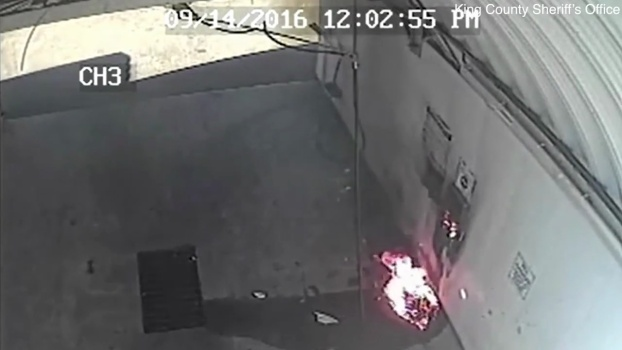

In [15]:
data = metadatas[10]
caption = data['transcript']
print(f'Generated caption is: "{caption}"')
frame = Image.open(data['extracted_frame_path'])
display(frame)

In [16]:
metadatas_path = osp.join(path_to_save_metadatas,'metadatas.json')
with open(metadatas_path, 'w') as outfile:
    json.dump(metadatas, outfile)